In [10]:
using PyPlot

if ispath("ikccd") == true
    rm("ikccd", recursive=true)
end
mkdir("ikccd")

### Homogene Transformationsmatrizen

In [11]:
RZ(θ) = [
    [cos(θ) -sin(θ) 0 0];
    [sin(θ) cos(θ) 0 0];
    [0 0 1 0];
    [0 0 0 1]
]

RX(α) = [
    [1 0 0 0]
    [0 cos(α) -sin(α) 0];
    [0 sin(α)  cos(α) 0];
    [0 0 0 1]
]

TZ(d) = [
    [1 0 0 0];
    [0 1 0 0];
    [0 0 1 d];
    [0 0 0 1]
]

TX(a) = [
    [1 0 0 a];
    [0 1 0 0];
    [0 0 1 0];
    [0 0 0 1]
]

A(θ, d, α, a) = RZ(θ) * TZ(d) * TX(a) * RX(α)

normalize(x) = x/norm(x)

normalize (generic function with 1 method)

In [12]:
A(π, 1, -π, 2)

4x4 Array{Float64,2}:
 -1.0           1.22465e-16  -1.49976e-32  -2.0        
  1.22465e-16   1.0          -1.22465e-16   2.44929e-16
  0.0          -1.22465e-16  -1.0           1.0        
  0.0           0.0           0.0           1.0        

### Definition Roboter

In [13]:
A1(θ) = A(θ,0,0,2)
A2(θ) = A(θ,0,0,1)
A3(θ) = A(θ,0,0,0.75)

A3 (generic function with 1 method)

### Direkte Kinematik

In [14]:
function ForwardKinematics(q)
    base = [0;0;0;1]
    
    θ1 = q[1]
    θ2 = q[2]
    θ3 = q[3]
    
    p1 = A1(θ1) * base
    p2 = A1(θ1) * A2(θ2) * base
    p3 = A1(θ1) * A2(θ2) * A3(θ3) * base
    
    [p1 p2 p3]
end

ForwardKinematics (generic function with 1 method)

### Plot Funktionen

In [15]:
function PlotRoboter(coords, goal)
    fig = figure(figsize=(8,5))
    xlim(-4,4)
    ylim(-1,4)
    xticks([])
    yticks([])
    
    plot([0,           coords[1,1]], [0,           coords[2,1]], color="red",    lw = 5.0)
    plot([coords[1,1], coords[1,2]], [coords[2,1], coords[2,2]], color="green",  lw = 5.0)
    plot([coords[1,2], coords[1,3]], [coords[2,2], coords[2,3]], color="blue",   lw = 5.0)
    plot([goal[1]-0.1, goal[1]+0.1], [goal[2]-0.1, goal[2]+0.1], color="purple", lw = 1.0)
    plot([goal[1]-0.1, goal[1]+0.1], [goal[2]+0.1, goal[2]-0.1], color="purple", lw = 1.0)
    fig
end

PlotRoboter (generic function with 1 method)

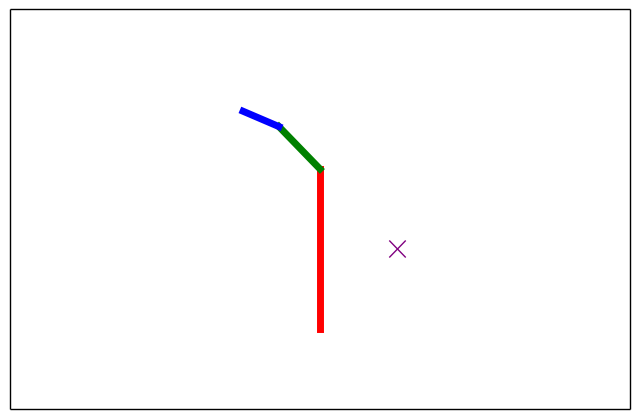

In [16]:
coords = ForwardKinematics([π/2 π/4 π/8])
PlotRoboter(coords, [1 1])

### Inverse Kinematik CCD

In [17]:
function InverseKinematicsCCD(goal, q)
    base = [0;0;0;1]
    δ = 0.01
    
    # Endeffektor
    e = A1(q[1]) * A2(q[2]) * A3(q[3]) * base
    
    # Drittes Segment
    p = A1(q[1]) * A2(q[2]) * base
    c = e[1:2] - p[1:2]
    t = goal - p[1:2]
    c = normalize([c;0])
    t = normalize([t;0])
    cθ = dot(c,t)
    if cθ < 1.0 # 1.0 -> θ = 0
        k = cross(t,c)
        θ = minimum([δ, acos(cθ)])
        if k[3] > 0
            q[3] = q[3] - θ
        else
            q[3] = q[3] + δ
        end
    end
    
    # Zweites Segment
    p = A1(q[1]) * base
    c = e[1:2] - p[1:2]
    t = goal - p[1:2]
    c = normalize([c;0])
    t = normalize([t;0])
    cθ = dot(c,t)
    if cθ < 1.0 # 1.0 -> θ = 0
        k = cross(t,c)
        θ = minimum([δ, acos(cθ)])
        if k[3] > 0
            q[2] = q[2] - θ
        else
            q[2] = q[2] + δ
        end
    end
    
    # Erstes Segment
    p = base
    c = e[1:2] - p[1:2]
    t = goal - p[1:2]
    c = normalize([c;0])
    t = normalize([t;0])
    cθ = dot(c,t)
    if cθ < 1.0 # 1.0 -> θ = 0
        k = cross(t,c)
        θ = minimum([δ, acos(cθ)])
        if k[3] > 0
            q[1] = q[1] - θ
        else
            q[1] = q[1] + δ
        end
    end
    q
end

q = [π/2 0.01 0.01]
goal = [1.0;2.0]
InverseKinematicsCCD(goal, q)

1x3 Array{Float64,2}:
 1.5608  0.0  0.0

In [18]:
q    = [π/2 0.01 0.01]
goal = [1.0; 1.0]
ϵ    = 0.1
j    = 0

ioff()

for i = 1:200
    j = j + 1
    q = InverseKinematicsCCD(goal, q)
    coords = ForwardKinematics(q)
    fig = PlotRoboter(coords,goal)
    savefig("ikccd/robot_$(j-1).png", bbox_inches="tight")
    close(fig)
end

goal = [0.0; 3.0]
for i = 1:400
    j = i + 1
    q = InverseKinematicsCCD(goal, q)
    fig = PlotRoboter(q,goal)
    savefig("ikccd/robot_$(j-1).png", bbox_inches="tight")
    close(fig)
end



goal = [-1.0; 0.5]
for i = 1:400
    j = i + 1
    q = InverseKinematicsCCD(goal, q)
    fig = PlotRoboter(q,goal)
    savefig("ikccd/robot_$(j-1).png", bbox_inches="tight")
    close(fig)
end

ion()    

LoadError: LoadError: BoundsError: attempt to access 1x3 Array{Float64,2}:
 0.857055  -2.0  -1.54817
  at index [2,1]
while loading In[18], in expression starting on line 18